### **Create your own Cancer Detection model**

## Import packages needed / Download Data

In [1]:
import tensorflow as tf # Import the TensorFlow library
from tensorflow import keras # Import Keras from TensorFlow for building neural networks
from keras import layers, optimizers, losses # Import specific modules from Keras: layers for model building, optimizers for training, and losses for calculating errors
from keras.applications import MobileNetV3Large # Import the MobileNetV3Large pre-trained model
from keras.applications.mobilenet_v3 import preprocess_input # Import the preprocessing function for MobileNetV3
from keras.preprocessing import image_dataset_from_directory, image # Import image data loading and processing utilities
import numpy as np # Import NumPy for numerical operations
import seaborn as sns # Import Seaborn for data visualization
from sklearn.metrics import confusion_matrix, classification_report # Import metrics for model evaluation
import matplotlib.pyplot as plt # Import Matplotlib for plotting
from tensorflow.keras.models import load_model # Import function to load saved Keras models

In [2]:
import kagglehub # Import the kagglehub library

# Download latest version of the dataset from Kaggle
path = kagglehub.dataset_download("obulisainaren/multi-cancer")

# Print the path where the dataset files are downloaded
print("Path to dataset files:", path)

100%|██████████| 8.62G/8.62G [01:45<00:00, 87.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3


## Load in the Brain Cancer Data and visulise

In [3]:
import os as os
BATCH = 16 # Define the batch size for loading the dataset
SIZE = (224,224) # Define the image size for resizing the images

directory = os.path.join(path,'Multi Cancer/Multi Cancer') # Construct the base directory path for the dataset

def filtered_data_loading(include_type, subset):
    # Print a message indicating which cancer type is being loaded
    print(f"Loading dataset for {include_type}")
    full_dir = directory
    # Construct the directory path for the specific cancer type
    directory1 = os.path.join(full_dir, include_type)

    # Load the image dataset from the directory using image_dataset_from_directory
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory1,
        labels="inferred", # Infer labels from directory structure
        label_mode="categorical", # Use one-hot encoded labels
        validation_split=0.2, # Reserve 20% of the data for validation
        subset=subset, # Specify whether to load the training or validation subset
        seed=123, # Set a seed for shuffling for reproducibility
        shuffle=True, # Shuffle the data
        batch_size=16, # Set the batch size
        image_size=(224, 224) # Set the image size
    )

# Load the main training and validation datasets including only "Brain Cancer"
main_dataset_train = filtered_data_loading("Brain Cancer", "training")
main_dataset_val = filtered_data_loading("Brain Cancer", "validation")

Loading dataset for Brain Cancer
Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Loading dataset for Brain Cancer
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


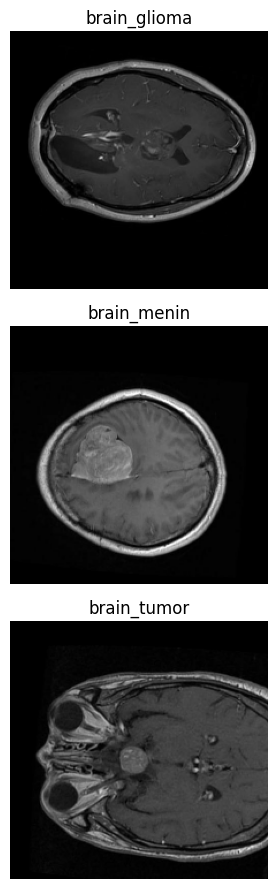

In [4]:
import math

class_names = main_dataset_train.class_names # Get the list of class names from the training dataset

rep_images = {cls: None for cls in class_names} # Initialize a dictionary to store one representative image for each class

# iterate until you’ve seen one image of each class
for batch in main_dataset_train.unbatch().batch(1): # Iterate through the training dataset, processing one image at a time
    img, label = batch # Unpack the image and its label from the batch
    idx = np.argmax(label.numpy()) # Get the index of the class with the highest probability (since labels are one-hot encoded)
    cls = class_names[idx] # Get the class name corresponding to the index
    if rep_images[cls] is None: # Check if a representative image for this class has already been collected
        rep_images[cls] = img[0].numpy().astype("uint8") # If not, store the current image (converting it to uint8 format)
    if all(v is not None for v in rep_images.values()): # Check if a representative image has been collected for all classes
        break # If all classes have a representative image, break the loop

n = len(class_names) # Get the number of classes
cols = 1 # Set the number of columns for the plot
rows = math.ceil(n / cols) # Calculate the number of rows needed based on the number of classes and columns

plt.figure(figsize=(cols * 3, rows * 3)) # Create a new figure for plotting with a specified size
for i, cls in enumerate(class_names): # Iterate through the class names with their indices
    ax = plt.subplot(rows, cols, i + 1) # Create a subplot for the current class
    ax.imshow(rep_images[cls]) # Display the representative image for the current class
    ax.set_title(cls) # Set the title of the subplot to the class name
    ax.axis("off") # Turn off the axes for the subplot

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plot

## Build the ML model

In [9]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# MobileNetV3Large is a pre-trained convolutional neural network architecture
# that is highly efficient and designed for mobile and embedded vision applications.
# It balances accuracy and latency/throughput by using a combination of:
# - Depthwise separable convolutions
# - Squeeze-and-Excite blocks
# - h-swish activation function
# It comes in two variants: Large and Small. We are using the Large version here.
# The pre-trained weights ('imagenet') allow us to leverage knowledge learned
# from a large dataset (ImageNet) and apply it to our specific task (cancer detection)
# through transfer learning.

def create_model(num_classes):
    # Load the pre-trained MobileNetV3 model
    pre_model = MobileNetV3Large(
        weights='imagenet', # Use weights pre-trained on ImageNet
        include_top=False, # Exclude the top classification layer
        input_shape=(224, 224, 3) # Define the input shape of the images (height, width, channels)
    )

    # Freeze the base model layers to use transfer learning
    pre_model.trainable = False # Set the layers of the pre-trained model to non-trainable

    # Add custom classification layers
    x = pre_model.output # Get the output tensor from the pre-trained model
    x = layers.GlobalAveragePooling2D()(x) # Add a Global Average Pooling layer to reduce spatial dimensions
    x = layers.Dense(1024, activation='relu')(x) # Add a dense layer with 1024 units and ReLU activation
    x = layers.Dense(512, activation='relu')(x) # Add a dense layer with 512 units and ReLU activation
    x = layers.Dense(128, activation='relu')(x) # Add a dense layer with 128 units and ReLU activation
    output_layer = layers.Dense(num_classes, activation='softmax')(x) # Add the output dense layer with softmax activation for classification

    # Create the final model
    model = models.Model(inputs=pre_model.input, outputs=output_layer) # Create a Keras Model by specifying input and output layers

    # Compile the model
    model.compile(
        loss='categorical_crossentropy', # Use categorical crossentropy as the loss function (suitable for multi-class classification)
        optimizer=Adam(learning_rate=0.0001), # Use the Adam optimizer with a specified learning rate
        metrics=['accuracy'] # Monitor accuracy during training
    )

    return model # Return the compiled model

In [10]:
def train_model(train_data, val_data, num_classes, model_name):
    model = create_model(num_classes) # Create the model using the create_model function
    history = model.fit(train_data, validation_data=val_data, epochs=2)  # Train the model on the training data and validate on the validation data for 10 epochs, storing the training history
    model.save(f"{model_name}_model.keras") # Save the trained model to a file with a name based on the cancer type
    return history, model  # Return the training history and the trained model

## Train the model

In [11]:
brain_dataset_train = filtered_data_loading("Brain Cancer", "training") # Load the training dataset for Brain Cancer
brain_dataset_val = filtered_data_loading("Brain Cancer", "validation") # Load the validation dataset for Brain Cancer

num_classes_brain = 3 # Define the number of classes for Brain Cancer
history, model = train_model(brain_dataset_train, brain_dataset_val, num_classes_brain, "brain_cancer") # Train the model for Brain Cancer and store the training history and model

# Now you can evaluate the model
loss, accuracy = model.evaluate(brain_dataset_val) # Evaluate the trained model on the validation dataset
print(f"Evaluation Results - Loss: {loss}, Accuracy: {accuracy}") # Print the evaluation results (loss and accuracy)

Loading dataset for Brain Cancer
Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Loading dataset for Brain Cancer
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Epoch 1/2
750/750 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.8839 - loss: 0.3051 - val_accuracy: 0.9743 - val_loss: 0.0801
Epoch 2/2
750/750 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.9759 - loss: 0.0699 - val_accuracy: 0.9773 - val_loss: 0.0747
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9767 - loss: 0.0759
Evaluation Results - Loss: 0.0747242271900177, Accuracy: 0.9773333072662354


## Save the Model then load it again

In [ ]:
model.save("brain_cancer_model.keras") # Save the model as a '.keras' file

In [ ]:
model = tf.keras.models.load_model("brain_cancer_model.keras") # Load back in the saved model

## Create different plotting functions

In [12]:
import matplotlib.pyplot as plt
def plot_class_distribution(dataset, title):
    class_counts = {}
    class_names = dataset.class_names  # Get class labels
    for images, labels in dataset:
        for label in labels.numpy():
            class_index = label.argmax()
            class_counts[class_names[class_index]] = class_counts.get(class_names[class_index], 0) + 1

    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

In [13]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Model Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Model Loss")

    plt.show()

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataset, class_names):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [15]:
def plot_sample_predictions(model, dataset, class_names):
    images, labels = next(iter(dataset))
    predictions = model.predict(images)

    num_images = images.shape[0]
    plt.figure(figsize=(10, 10))
    for i in range(min(9, num_images)):  # Show up to 9 images, but not more than available
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = class_names[np.argmax(predictions[i])]
        true_label = class_names[np.argmax(labels[i].numpy())]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color="green" if pred_label == true_label else "red")
        plt.axis("off")
    plt.show()

In [16]:
import numpy as np
import cv2
import tensorflow as tf

def generate_gradcam_heatmap(model, image, class_index, last_conv_layer_name="conv_1_bn"):

    # Create a model that outputs the last conv layer and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]

    # Gradient of loss w.r.t. conv layer output
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)  # avoid div by zero
    heatmap = heatmap.numpy()

    # Resize heatmap to match input image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Prepare original image for overlay
    img_display = image[0].numpy()
    if np.max(img_display) <= 1.0:
        img_display = np.uint8(255 * img_display)
    else:
        img_display = np.uint8(img_display)

    # If grayscale, convert to 3 channels
    if img_display.shape[-1] == 1:
        img_display = np.repeat(img_display, 3, axis=-1)

    # Convert to BGR for OpenCV overlay
    img_display_bgr = cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR)

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(img_display_bgr, 0.6, heatmap_colored, 0.4, 0)

    # Display
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img_display_bgr, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap_resized, cmap='jet')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Superimposed")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## Use the plots we just created

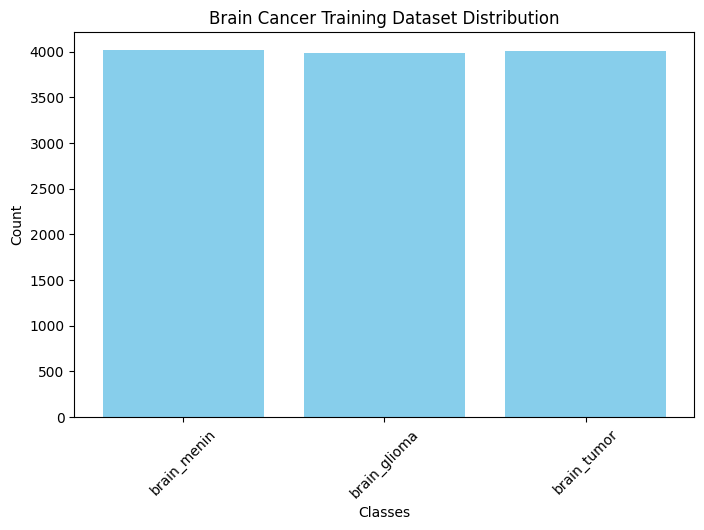

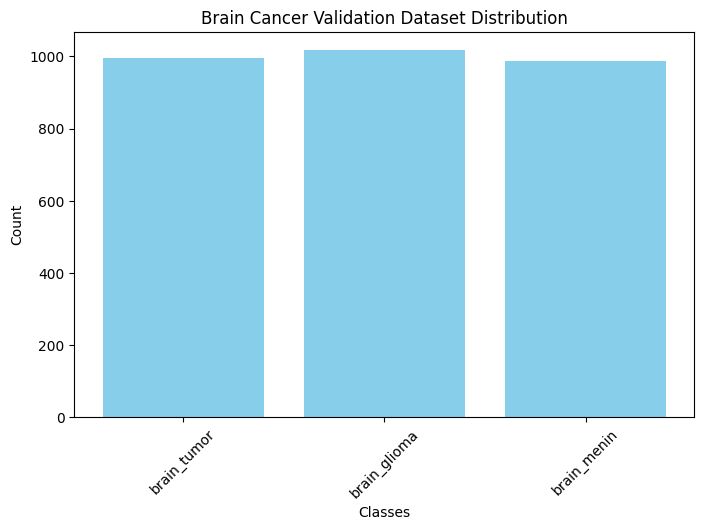

In [17]:
plot_class_distribution(brain_dataset_train, "Brain Cancer Training Dataset Distribution") # Run the plot for the Training data
plot_class_distribution(brain_dataset_val, "Brain Cancer Validation Dataset Distribution") # Run the plot for the validation data

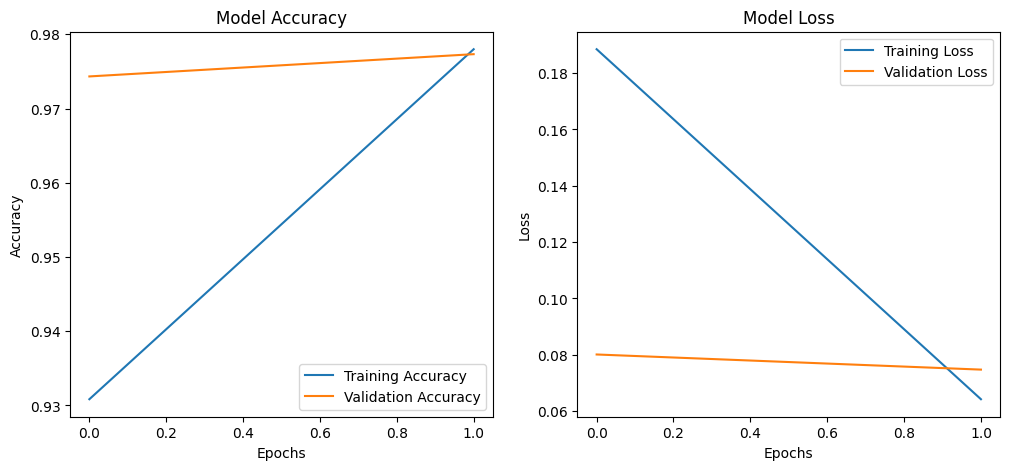

In [18]:
plot_training_history(history) # Plot the training history

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━

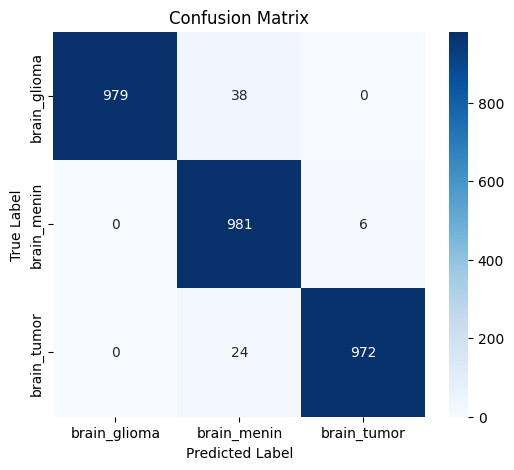

In [19]:
plot_confusion_matrix(model, brain_dataset_val, brain_dataset_val.class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


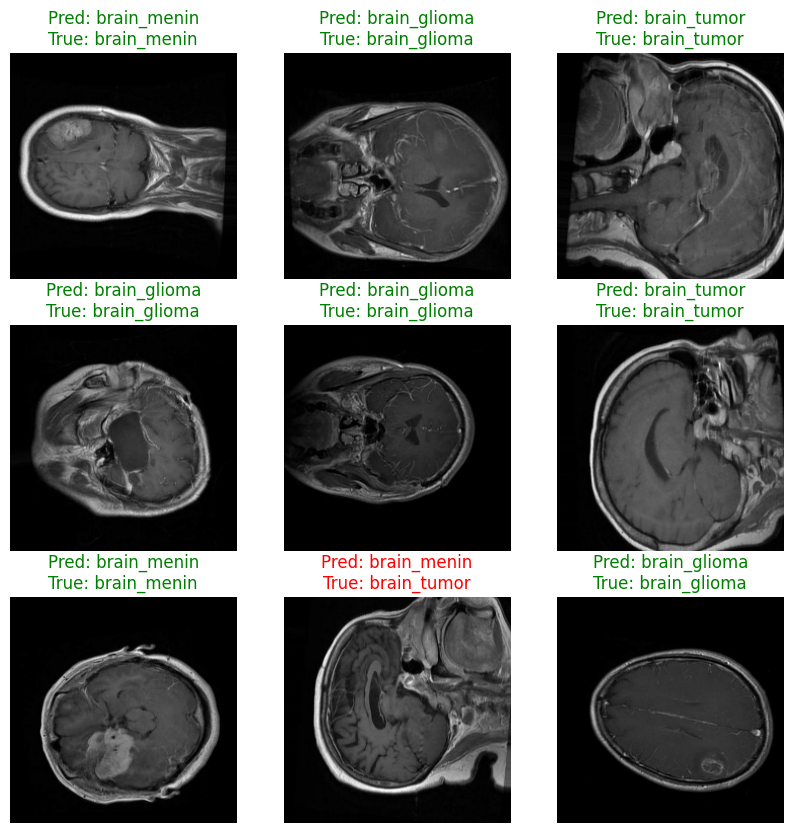

In [20]:
plot_sample_predictions(model, brain_dataset_val, brain_dataset_val.class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_208']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


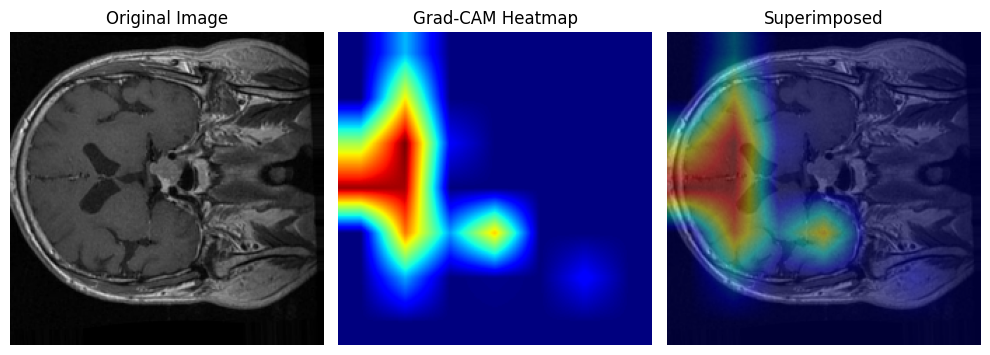

In [21]:
# Get a batch from your validation dataset
image_batch, label_batch = next(iter(brain_dataset_val))
image = image_batch[0]
label = label_batch[0]

# Add batch dimension
image_input = tf.expand_dims(image, axis=0)

# Predict the class
preds = model.predict(image_input)
predicted_class = tf.argmax(preds[0])

# Run Grad-CAM for the predicted class
generate_gradcam_heatmap(model, image_input, class_index=predicted_class)